In [127]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [128]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [129]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

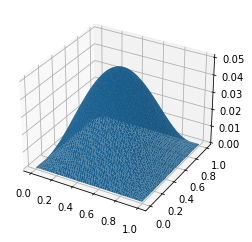

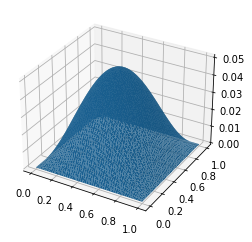

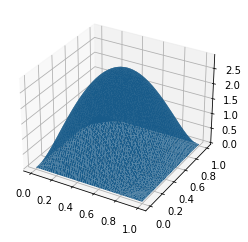

poucentage d'erreur : 0.05711%


In [130]:
######### Partie 1 : Maillage triangulaire et conditions de Dirichlet
## Données
n = 10
coordinates,elements3,dirichlet,neumann = maillage(n)


########################################  Etape 1 : Construction de la matrice de raideur ́elementaire M ################################################################
def raideur_elementaire_triangle(indice_triangle):
    # Initialisation des données
    coordonnees = []
    for i in range(len(indice_triangle)):
        coordonnees.append(coordinates[indice_triangle[i]])
    dist = np.zeros((2,2))

    # Calcul de l'aire du triangle
    dist[0,0] = coordonnees[1][0]-coordonnees[0][0]
    dist[0,1] = coordonnees[2][0]-coordonnees[0][0]
    dist[1,0] = coordonnees[1][1]-coordonnees[0][1]
    dist[1,1] = coordonnees[2][1]-coordonnees[0][1]
    alpha = np.linalg.det(dist)
    aire = abs(alpha/2)
    

    # Calcul des valeurs du gradient de eta
    p = 3
    l_grad_eta = []
    for j in range (p):
        grad_eta = np.zeros((2))
        grad_eta[0] = (1/alpha)*(coordonnees[(j+1)%3][1] - coordonnees[(j+2)%3][1])
        grad_eta[1] = (1/alpha)*(coordonnees[(j+2)%3][0] - coordonnees[(j+1)%3][0])
        l_grad_eta.append(grad_eta)

    # Calcul des valeurs de M
    M = np.zeros((p,p))
    for i in range(p):
        for j in range(p):
            #Calcul de Mij
            M[i][j] = aire * (l_grad_eta[i][0]*l_grad_eta[j][0] + l_grad_eta[i][1]*l_grad_eta[j][1])
    return M




####################################################  Etape 2 : Assemblage de la matrice A  ######################################################################


def assemblage_matrice_triangle():
    p = 3
    m = n*n
    A = np.zeros ((m,m))
    for t in range(len(elements3)):
        curr = elements3[t]
        M = raideur_elementaire_triangle(curr)
        for i in range(p):
            for j in range(p):
                A[curr[i]][curr[j]] += M[i][j]
    return A

    
#print(raideur_elementaire([13,2,1]))
#print(assemblage_matrice())
#A = assemblage_matrice()



####################################################  Etape 3  : Assemblage du second membre  ######################################################################


def centre_gravité (coordonnees):
    xg = 0
    yg = 0
    for i in range(len(coordonnees)):
        xg += coordonnees[i][0]
        yg += coordonnees[i][1]
    return xg/3 , yg/3
    
def alpha (coordonnees):
    dist = np.zeros((2,2))
    dist[0,0] = coordonnees[1][0]-coordonnees[0][0]
    dist[0,1] = coordonnees[2][0]-coordonnees[0][0]
    dist[1,0] = coordonnees[1][1]-coordonnees[0][1]
    dist[1,1] = coordonnees[2][1]-coordonnees[0][1]
    alpha = np.linalg.det(dist)
    return alpha

def assemblage_sm_triangle (Ud):
    m=n*n
    B = np.zeros(m)
    ## Calcul du second membre global
    for i in range (len(elements3)):
        curr = elements3[i]
        coordonnees = []
        # On récupère les coordonnées de chaque élément du triangle
        for t in range(len(curr)):
           coordonnees.append(coordinates[curr[t]])

        # On calcule le centre de gravité
        xg , yg = centre_gravité (coordonnees)

        #On calcule l'intégrale de f
        intf = (alpha(coordonnees)/6)*f_function(xg,yg)

        #On l'ajoute à B dans les 3 composantes qu'il faut
        for t in range(len(curr)):
            B[curr[t]] += intf

    ## Ajout des conditions de Dirichlet
    for i in range (len(dirichlet)):
        for k in range (len(dirichlet)):
            #B[i] -= Ud[coordinates[dirichlet[k]]] * A[i][dirichlet[k]]
            B[i] -= Ud[k] * A[i][dirichlet[k]]
    return(B)

#######################################################  Section de test  ######################################################################
n = 50
coordinates,elements3,dirichlet,neumann = maillage(n)

def f_function(x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)

# Création de A et de B
A = assemblage_matrice_triangle()
Ud = np.zeros(n*n)
for i in range(n*n):
   Ud[i] = 0

B = assemblage_sm_triangle (Ud)

# Réduction de A et B (pouvoir inverser A)
# On trouve les indices à garder 
indices_choisis = []
for i in range(len(coordinates)):
    if not(i in dirichlet):
        indices_choisis.append(i)

# On réduit A et B
p = len(indices_choisis)
A_reduit = np.zeros((p,p))
B_reduit = np.zeros(p)
for i in range(p):
    B_reduit[i] = B[indices_choisis[i]]
    for j in range(p):
        A_reduit[i][j] = A[indices_choisis[i]][indices_choisis[j]]

# Résolution du système linéaire
X = np.linalg.solve(A_reduit,B_reduit)

# On reconstruit la solution (on concatène la solution interne et au bord)
sol_fin = np.zeros(len(coordinates))
for i in range(len(indices_choisis)):
    sol_fin[indices_choisis[i]]= X[i]

for i in range(len(dirichlet)):
    sol_fin[dirichlet[i]]= Ud[i]

# Affichage de la solution
# print(sol_fin)
show(coordinates, sol_fin)


# Affichage de la solution théorique
sol_theo = np.zeros(len(coordinates))
for i in range(len(sol_theo)):
    curr = coordinates[i]
    sol_theo[i] = 1/(2*(np.pi)**2) * f_function(curr[0], curr[1])
show(coordinates, sol_theo)

# Création du vecteur d'erreur
err = np.abs(sol_theo - sol_fin)
show(coordinates, err)

# Ordre de grandeur du pourcentage d'erreur
p_err_max = max(err)/max(abs(sol_theo)) * 100
print("poucentage d'erreur : " + str(round(p_err_max,5)) + "%")


### Analyse du résultat

Nous avons décidé de prendre une fonction test f(x,y) = sin(&pi;*x)*sin(&pi;*y) dont nous conaissions la solution u(x,y) = 1/(2*(&pi;)**2) * f(x,y). Nous avons donc comparé la solution théorique et expérimentale. On obtient un pourcentage d'erreur relatif très faible (autour de 0.05%) pour n = 50. 

Le résultat est donc très cohérent , nous validons notre algorithme sur la première partie.

In [131]:
def f_function(x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)


# Evolution de l'erreur relative en fonction de n
nb_it = 10
err = np.zeros(nb_it)
N = np.zeros(nb_it)
for k in range (1,nb_it):
    n= k*5
    coordinates,elements3,dirichlet,neumann = maillage(n)
    N[k] = n
    # Création de A et de B
    A = np.zeros((n*n,n*n))
    A = assemblage_matrice_triangle()
    Ud = np.zeros(n*n)
    for i in range(n*n):
        Ud[i] = 0

    B = assemblage_sm_triangle (Ud)

    # Réduction de A et B (pouvoir inverser A)
    # On trouve les indices à garder 
    indices_choisis = []
    for i in range(len(coordinates)):
        if not(i in dirichlet):
            indices_choisis.append(i)

    # On réduit A et B
    p = len(indices_choisis)
    A_reduit = np.zeros((p,p))
    B_reduit = np.zeros(p)
    for i in range(p):
        B_reduit[i] = B[indices_choisis[i]]
        for j in range(p):
            A_reduit[i][j] = A[indices_choisis[i]][indices_choisis[j]]

    # Résolution du système linéaire
    X = np.linalg.solve(A_reduit,B_reduit)

    # On reconstruit la solution (on concatène la solution interne et au bord)
    sol_fin = np.zeros(len(coordinates))
    for i in range(len(indices_choisis)):
        sol_fin[indices_choisis[i]]= X[i]

    for i in range(len(dirichlet)):
        sol_fin[dirichlet[i]]= Ud[i]

    # Calcul de la solution théorique
    sol_theo = np.zeros(len(coordinates))
    for i in range(len(sol_theo)):
        curr = coordinates[i]
        sol_theo[i] = 1/(2*(np.pi)**2) * f_function(curr[0], curr[1])

    # Création du vecteur d'erreur
    err2 = np.abs(sol_theo - sol_fin)

    # Ordre de grandeur du pourcentage d'erreur
    p_err_max = max(err2)/max(abs(sol_theo))
    err[k] = np.log10(p_err_max)

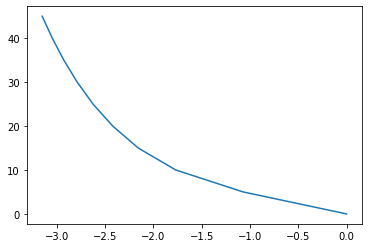

In [132]:
plt.plot(err, N)

### Analyse de la courbe
Nous avons voulu tracé l'erreur relative en fonction de n. On remarque que plus on augmente n plus la précision augmente et donc l'erreur tend vers 0. En prenant un n très grand on s'approche de la solution parfaite.

On remarque de plus une allure exponoentielle décroissante de la courbe.

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [133]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
#dds=np.array([2,15,4,5,6,7,8,9,10,11,0,1]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [134]:
########################################  Etape 1 : Construction de la matrice de raideur ́elementaire M ################################################################
# Calcul de la matrice raideur élementaire du triangle
def raideur_elementaire_tria(indice_triangle,elements3, coordinates, f):
    # Initialisation des données
    triangle = elements3[indice_triangle]
    

    # Récupération des coordonnées des sommets du triangle
    x1 = coordinates[triangle[0]][0]
    y1 = coordinates[triangle[0]][1]
    x2 = coordinates[triangle[1]][0]
    y2 = coordinates[triangle[1]][1]
    x3 = coordinates[triangle[2]][0]
    y3 = coordinates[triangle[2]][1]

    # Calcul de l'aire du triangle
    dist = np.zeros((2,2))
    dist[0,0] = x2 - x1
    dist[0,1] = x3 - x1
    dist[1,0] = y2 - y1
    dist[1,1] = y3 - y1
    alpha = np.linalg.det(dist)
    aire = abs(alpha/2)



    
    p = 3
    grad_etha_i=np.zeros((2,1))
    grad_etha_j=np.zeros((2,1))
    M = np.zeros((3,3))
    for i in range(p):
        for j in range(p):
            grad_etha_i[0] = (1/alpha)*(coordinates[triangle[(i+1)%3]][1] - coordinates[triangle[(i+2)%3]][1])
            grad_etha_i[1] = (1/alpha)*(coordinates[triangle[(i+2)%3]][0] - coordinates[triangle[(i+1)%3]][0])
            grad_etha_j[0] = (1/alpha)*(coordinates[triangle[(j+1)%3]][1] - coordinates[triangle[(j+2)%3]][1])
            grad_etha_j[1] = (1/alpha)*(coordinates[triangle[(j+2)%3]][0] - coordinates[triangle[(j+1)%3]][0])
            M[i,j]= aire * (grad_etha_i[0]*grad_etha_j[0] + grad_etha_i[1]*grad_etha_j[1])


     #On calcule l'intégrale de f
      # Barycentre 
    xg = (x1+x2+x3)/3
    yg = (y1+y2+y3)/3
    intf = (alpha/6)*f(xg,yg)
            

    
    return M , intf

In [135]:
# Calcul de la matrice de raideur des rectangles
def raideur_elementaire_rectangla(sommets, coordinates, f):
    # Initialisation des données

    x1 = coordinates[sommets[0],0]
    y1 = coordinates[sommets[0],1]
    x2 = coordinates[sommets[1],0]
    y2 = coordinates[sommets[1],1]
    x3 = coordinates[sommets[2],0]
    y3 = coordinates[sommets[2],1]
    x4 = coordinates[sommets[3],0]
    y4 = coordinates[sommets[3],1]

    # Calcul de la jacobienne de Phi (Elle ne dépend pas de i et j)
    Jacob = np.zeros((2,2))
    Jacob[0,0] = x2 - x1
    Jacob[0,1] = x4 - x1
    Jacob[1,0] = y2 - y1
    Jacob[1,1] = y4 - y1
    det = np.linalg.det(Jacob)
  
    # Calcul de l'inverse de Phi'*Phi (élément constant)
    M_a_inv = np.transpose(Jacob)*Jacob

    # Calcul de N1, N2 et N4
    a = M_a_inv[1,1]
    b = - M_a_inv[0,1]
    c = - M_a_inv[1,0]
    d = M_a_inv[0,0]
    terme_jacob = np.array([[a,- b],[- b,d]])/(d*a-b**2)
    N1 = terme_jacob[0,0]
    N2 = terme_jacob[1,0]
    N4 = terme_jacob[1,1]

    # Calcul de la matrice de raideur
    M_raideur =  np.zeros((4,4))
    M_raideur[0,0] = (det/6)* (2*N1 + 2*N4 + 3*N2)
    M_raideur[1,0] = (det/6) * (N4 - 2*N1)
    M_raideur[2,0] = (det/6) * (-N1 - N4 -3*N2)
    M_raideur[3,0] = (det/6) * (N1 - 2*N4)
    M_raideur[1,1] = (det/6) * (2*N1 + 2*N4 -3*N2)
    M_raideur[1,2] = (det/6) * (N1 - 2*N4)
    M_raideur[1,3] = (det/6) * (-N1 - N4 + 3*N2)
    M_raideur[2,2] = (det/6) * (2*N1 + 2*N4 + 3*N2)
    M_raideur[2,3] = (det/6) * (N4 - 2*N1)
    M_raideur[3,3] = (det/6) * (2*N1 + 2*N4 -3*N2)

    # On obtient les autres coeff par symétrie
    M_raideur[0,1] = M_raideur[1,0]
    M_raideur[0,2] = M_raideur[2,0]
    M_raideur[0,3] = M_raideur[3,0]
    M_raideur[2,1] = M_raideur[1,2]
    M_raideur[3,1] = M_raideur[1,3]
    M_raideur[3,2] = M_raideur[2,3]

    #On calcule l'intégrale de f
    # Barycentre
    xg = (x1+x2+x3+x4)/4
    yg = (y1+y2+y3+y4)/4
    intf = (det/4)*f(xg,yg)

    return M_raideur , intf

In [136]:
############################################### Etape 2 : Assemblage de la matrice A et du second membre ################################################################
def assemblage_mixte (elements3, elements4, coordinates,dirichlet, N, f, g, ud):
 

#Initialisation des matrices et vecteurs
  A = np.zeros((len(coordinates),len(coordinates)))
  B = np.zeros((len(coordinates),1))
  u = np.zeros((len(coordinates),1))

  #Condition de Dirichlet
  for h in range(len(dirichlet)):
    u[dirichlet[h]] = ud(coordinates[dirichlet[h]][0],coordinates[dirichlet[h]][1])

  # Assemblage de la matrice A et du second membre B
  # Iteration sur les triangles
  p = 3
  for i in range(len(elements3)):
    M,z = raideur_elementaire_tria(i,elements3, coordinates, f)
    triangle = elements3[i]
    for j in range (p):
      for k in range (p):
        A[triangle[j],triangle[k]] += M[j][k]
      B[triangle[j]] += z

  # Iteration sur les quadrangle
  for i in elements4:
    M,z = raideur_elementaire_rectangla(i,coordinates, f)
    quadrangle = i
    s = 4
    for j in range (s):
      for k in range (s):
        A[quadrangle[j],quadrangle[k]] += M[j][k]
      B[quadrangle[j]] += z

  # Introduction des conditions de Neumann
  for i,j in N :
        #Calcul de la distance entre les points
        ecartx, ecarty = ccs[i] - ccs[j]
        ecartx = (coordinates[i][0]-coordinates[j][0])
        ecarty = (coordinates[i][1]-coordinates[j][1])
        dist = np.sqrt(ecartx**2 + ecarty ** 2)
         #Calcul du centre
        xc, yc = (ccs[i] + ccs[j])/2
        xc = (coordinates[i][0]+coordinates[j][0])/2
        yc = (coordinates[i][1]+coordinates[j][1])/2
        #Approx de la valeur ajoutée
        v = g(xc,yc) * dist/2
        B[i] += v
        B[j] += v

  B -= np.dot(A,u)  
  

    

  return A,B,u

In [142]:
def ud(x,y):
    return 1

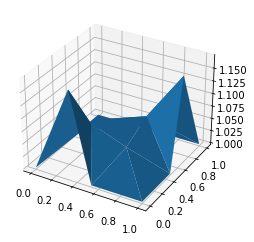

In [144]:
#######################################################  Section de test  ######################################################################

# Définition des fonctions
def f(x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)
def g(x,y):
    return 1



A,B,sol_fin = assemblage_mixte (e3, e4, ccs, dds, nns, f, g, ud)


indices = [i for i in range(len(ccs))]
indices_choisis= np.setdiff1d(indices, dds)
A_bis = A[indices_choisis]
A_reduit = A_bis[:,indices_choisis]
B_reduit= B[indices_choisis]

# Résolution du problème
sol_fin[indices_choisis] = np.linalg.solve(A_reduit,B_reduit)

# Affichage de la solution
show(ccs, (sol_fin[:,0]))




### Analyse du résultat 
Nous obtenons au final cette solution, malheureusement les conditions de Neumann ajoutées à celles de Dirichlet nous ont empéché de résoudre théoriquement l'équation. Nous ne pouvons pas valider notre résolution sur cette partie bien que nous ayons vérifié la cohérence des valeurs de A,B,etc ...

**Compléments  :  un nouveau terme dans l'EDP**

In [138]:
########################################  Etape 1 : Construction de la matrice de raideur ́elementaire M ################################################################
# définition de la fonction etha
def etha(x,y,x1,x2,x3,y1,y2,y3):
    etha = np.zeros((3,3))
    etha[0,0] = 1
    etha[1,0] = 1
    etha[2,0] = 1
    etha[0,1] = x
    etha[0,2] = y
    etha[1,1] = x2
    etha[1,2] = y2
    etha[2,1] = x3
    etha[2,2] = y3
    det_num = np.linalg.det(etha)
    etha[0,1] = x1
    etha[0,2] = y1
    det_denum = np.linalg.det(etha)

    return det_num/det_denum

# Calcul de la matrice raideur élementaire du triangle
def raideur_elementaire_tri(indice_triangle,elements3, coordinates, f, c):
    # Initialisation des données
     # Récupération du triangle
    triangle = elements3[indice_triangle]

    # Récupération des coordonnées des sommets du triangle
    x1 = coordinates[triangle[0]][0]
    y1 = coordinates[triangle[0]][1]
    x2 = coordinates[triangle[1]][0]
    y2 = coordinates[triangle[1]][1]
    x3 = coordinates[triangle[2]][0]
    y3 = coordinates[triangle[2]][1]

    # Calcul de l'aire du triangle
    dist = np.zeros((2,2))
    dist[0,0] = x2 - x1
    dist[0,1] = x3 - x1
    dist[1,0] = y2 - y1
    dist[1,1] = y3 - y1
    alpha = np.linalg.det(dist)
    aire = abs(alpha/2)
    
    p = 3
    grad_etha_i=np.zeros((2,1))
    grad_etha_j=np.zeros((2,1))
    M = np.zeros((3,3))
    for i in range(p):
        for j in range(p):
            grad_etha_i[0] = (1/alpha)*(coordinates[triangle[(i+1)%3]][1] - coordinates[triangle[(i+2)%3]][1])
            grad_etha_i[1] = (1/alpha)*(coordinates[triangle[(i+2)%3]][0] - coordinates[triangle[(i+1)%3]][0])
            grad_etha_j[0] = (1/alpha)*(coordinates[triangle[(j+1)%3]][1] - coordinates[triangle[(j+2)%3]][1])
            grad_etha_j[1] = (1/alpha)*(coordinates[triangle[(j+2)%3]][0] - coordinates[triangle[(j+1)%3]][0])
            xi = coordinates[triangle[i]][0]
            yi = coordinates[triangle[i]][1]
            xj = coordinates[triangle[j]][0]
            yj = coordinates[triangle[j]][1]
            prod_etha = etha(xi,yi,x1,x2,x3,y1,y2,y3) * etha(xj,yj,x1,x2,x3,y1,y2,y3)
            M[i,j]= aire * (grad_etha_i[0]*grad_etha_j[0] + grad_etha_i[1]*grad_etha_j[1]) + c * prod_etha


     #On calcule l'intégrale de f
      # Barycentre 
    xg = (x1+x2+x3)/3
    yg = (y1+y2+y3)/3
    intf = (alpha/6)*f(xg,yg)
            

    
    return M , intf

In [139]:
############################################### Etape 2 : Assemblage de la matrice A et du second membre ################################################################
def assemblage_3 (elements3, coordinates,dirichlet, f, ud , c):
  l = len(coordinates)
  A = np.zeros((l,l))
  B = np.zeros((l,1))
  u = np.zeros((l,1))

  #Condition aux limites
  for h in range(len(dirichlet)):
    u[h] = ud(coordinates[h][0],coordinates[h][1])

  # Assemblage de la matrice A et le vecteur B
  # Triangle
  p = 3
  for i in range(len(elements3)):
    M,z = raideur_elementaire_tri(i,elements3, coordinates, f, c)
    triangle = elements3[i]
    for j in range (p):
      for k in range (p):
        A[triangle[j],triangle[k]] += M[j][k]
      B[triangle[j]] += z

 


  B -= np.dot(A,u)  
  

    

  return A,B,u

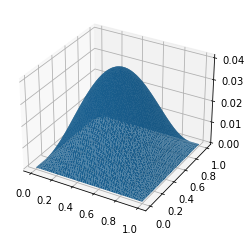

In [140]:
######### Partie 1 : Maillage triangulaire et conditions de Dirichlet
## Données
n = 10
coordinates,elements3,dirichlet,neumann = maillage(n)




########################################  Etape 1 : Construction de la matrice de raideur ́elementaire M ################################################################

# définition de la fonction etha
def etha(x,y,x1,x2,x3,y1,y2,y3):
    etha = np.zeros((3,3))
    etha[0,0] = 1
    etha[1,0] = 1
    etha[2,0] = 1
    etha[0,1] = x
    etha[0,2] = y
    etha[1,1] = x2
    etha[1,2] = y2
    etha[2,1] = x3
    etha[2,2] = y3
    det_num = np.linalg.det(etha)
    etha[0,1] = x1
    etha[0,2] = y1
    det_denum = np.linalg.det(etha)

    return det_num/det_denum

def raideur_elementaire_trianglea(indice_triangle,c):
    # Initialisation des données
    coordonnees = []
    for i in range(len(indice_triangle)):
        coordonnees.append(coordinates[indice_triangle[i]])
    dist = np.zeros((2,2))

    # Calcul de l'aire du triangle
    dist[0,0] = coordonnees[1][0]-coordonnees[0][0]
    dist[0,1] = coordonnees[2][0]-coordonnees[0][0]
    dist[1,0] = coordonnees[1][1]-coordonnees[0][1]
    dist[1,1] = coordonnees[2][1]-coordonnees[0][1]
    alpha = np.linalg.det(dist)
    aire = abs(alpha/2)
    
    #Initialisation des xi et yi
    x1 = coordinates[indice_triangle[0]][0]
    y1 = coordinates[indice_triangle[0]][1]
    x2 = coordinates[indice_triangle[1]][0]
    y2 = coordinates[indice_triangle[1]][1]
    x3 = coordinates[indice_triangle[2]][0]
    y3 = coordinates[indice_triangle[2]][1]
    
    # Calcul des valeurs du gradient de eta
    p = 3
    l_grad_eta = []
    for j in range (p):
        grad_eta = np.zeros((2))
        grad_eta[0] = (1/alpha)*(coordonnees[(j+1)%3][1] - coordonnees[(j+2)%3][1])
        grad_eta[1] = (1/alpha)*(coordonnees[(j+2)%3][0] - coordonnees[(j+1)%3][0])
        l_grad_eta.append(grad_eta)

    # Calcul des valeurs de M
    M = np.zeros((p,p))
    for i in range(p):
        for j in range(p):
            #Calcul de Mij
            xi = coordinates[indice_triangle[i]][0]
            yi = coordinates[indice_triangle[i]][1]
            xj = coordinates[indice_triangle[j]][0]
            yj = coordinates[indice_triangle[j]][1]
            prod_etha = etha(xi,yi,x1,x2,x3,y1,y2,y3) * etha(xj,yj,x1,x2,x3,y1,y2,y3)
            # On ajoute le terme lié à c 
            M[i][j] = aire * (l_grad_eta[i][0]*l_grad_eta[j][0] + l_grad_eta[i][1]*l_grad_eta[j][1]) + c * prod_etha

    return M




####################################################  Etape 2 : Assemblage de la matrice A  ######################################################################


def assemblage_matrice_trianglea(c):
    p = 3
    m = n*n
    A = np.zeros ((m,m))
    for t in range(len(elements3)):
        curr = elements3[t]
        M = raideur_elementaire_trianglea(curr,c)
        for i in range(p):
            for j in range(p):
                A[curr[i]][curr[j]] += M[i][j]
    return A

    
#print(raideur_elementaire([13,2,1]))
#print(assemblage_matrice())
#A = assemblage_matrice()



####################################################  Etape 3  : Assemblage du second membre  ######################################################################


def centre_gravité (coordonnees):
    xg = 0
    yg = 0
    for i in range(len(coordonnees)):
        xg += coordonnees[i][0]
        yg += coordonnees[i][1]
    return xg/3 , yg/3
    
def alpha (coordonnees):
    dist = np.zeros((2,2))
    dist[0,0] = coordonnees[1][0]-coordonnees[0][0]
    dist[0,1] = coordonnees[2][0]-coordonnees[0][0]
    dist[1,0] = coordonnees[1][1]-coordonnees[0][1]
    dist[1,1] = coordonnees[2][1]-coordonnees[0][1]
    alpha = np.linalg.det(dist)
    return alpha

def assemblage_sm_triangle (Ud):
    m=n*n
    B = np.zeros(m)
    ## Calcul du second membre global
    for i in range (len(elements3)):
        curr = elements3[i]
        coordonnees = []
        # On récupère les coordonnées de chaque élément du triangle
        for t in range(len(curr)):
           coordonnees.append(coordinates[curr[t]])

        # On calcule le centre de gravité
        xg , yg = centre_gravité (coordonnees)

        #On calcule l'intégrale de f
        intf = (alpha(coordonnees)/6)*f_func(xg,yg)

        #On l'ajoute à B dans les 3 composantes qu'il faut
        for t in range(len(curr)):
            B[curr[t]] += intf

    ## Ajout des conditions de Dirichlet
    for i in range (len(dirichlet)):
        for k in range (len(dirichlet)):
            #B[i] -= Ud[coordinates[dirichlet[k]]] * A[i][dirichlet[k]]
            B[i] -= Ud[k] * A[i][dirichlet[k]]
    return(B)

#######################################################  Section de test  ######################################################################
n = 50
c = 0.001
coordinates,elements3,dirichlet,neumann = maillage(n)

def f_func(x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)

# Création de A et de B
A = assemblage_matrice_trianglea(c)
Ud = np.zeros(n*n)
for i in range(n*n):
   Ud[i] = 0

B = assemblage_sm_triangle (Ud)

# Réduction de A et B (pouvoir inverser A)
# On trouve les indices à garder 
indices_choisis = []
for i in range(len(coordinates)):
    if not(i in dirichlet):
        indices_choisis.append(i)

# On réduit A et B
p = len(indices_choisis)
A_reduit = np.zeros((p,p))
B_reduit = np.zeros(p)
for i in range(p):
    B_reduit[i] = B[indices_choisis[i]]
    for j in range(p):
        A_reduit[i][j] = A[indices_choisis[i]][indices_choisis[j]]

# Résolution du système linéaire
X = np.linalg.solve(A_reduit,B_reduit)

# On reconstruit la solution (on concatène la solution interne et au bord)
sol_fin = np.zeros(len(coordinates))
for i in range(len(indices_choisis)):
    sol_fin[indices_choisis[i]]= X[i]

for i in range(len(dirichlet)):
    sol_fin[dirichlet[i]]= Ud[i]

# Affichage de la solution
# print(sol_fin)
show(coordinates, sol_fin)


        



### Analyse du résultat

Nous avons décidé de tester avec la même fonction test de la partie 1 tout en modifiant les valeurs de c. On remarque bien que c a un impact sur la solution finale ce qui est rassurant. Pour c = 0 on retrouve la même solution de la partie 1.

De plus, nous avons tester avec f = 0 car la solution à cette équation est très facile (u = 0) et nous trouvons bien u = 0 pour f = 0. La méthode de résolution pour cette partie semble cohérente.



## Conclusion

Nous avons implémenté les 3 parties pour résoudre les 3 équations différentielles, le résultat semble à chaque fois cohérent. Nous avons manipulé différents maillages, nous pouvons remarquer que selon les maillages les expressions théoriques pour la résolution approchée sont différentes. Ceci induit que selon le maillage que l'on choisit nous pouvons obtenir une bonne solution ou non. Il serait intéressant de s'intéresser à d'autres formes de maillages afin de mieux déterminer l'importance de ceux-ci.

En ce qui concerne le projet, nous avons finalement réussi à résoudre des équations complexes grâce à des méthodes approchées. Il a fallu lier calcul théorique, implémentation et définitions de tests. C'était un exercice assez complet et nous sommes plutôt satisfaits de notre travail. 